*2G Overshooting Classification Prediction By Roukaia Khelifi*

Radio overshooting in 2G (Second Generation) mobile networks refers to a situation where a mobile device receives a signal from a base station that extends beyond the intended coverage area. This can lead to suboptimal network performance, increased interference, and unnecessary power consumption in both the mobile device and the base station.

* Tilt:
Tilt refers to the angle at which the mobile network antennas are positioned in the vertical plane. It is used to control the coverage area and the direction of the signal.

Impact on Overshooting: Incorrect tilt settings can lead to overshooting. If the antennas are tilted too much downward, the coverage area may be limited, and users at the edges of the cell may experience poor signal quality. Conversely, if the antennas are tilted too much upward, the signal may extend beyond the intended coverage area, resulting in overshooting.

* Ret:
Ret involves adjusting the tilt of antennas to optimize coverage patterns and address specific network issues.

Impact on Overshooting: If retilting is not performed correctly or is not aligned with the network's requirements, it can contribute to overshooting. For example, improper retilting might extend coverage into areas where it is not needed, causing interference and reducing overall network efficiency.



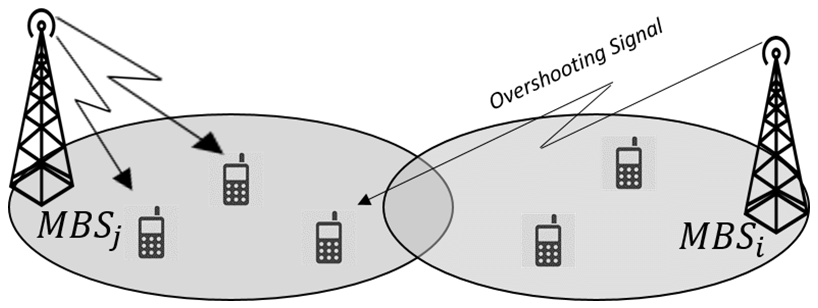

Importing Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

Importing Dataset

In [2]:
df = pd.read_excel("overshooting_audit_gsm.xlsx")

A brief Statistical Overview

In [33]:
df.describe().head(2)

,Cell CI,ISD(KM),0 KM <> 0.6 KM,0.6 KM <> 1.1 KM,1.1 KM <> 1.7 KM,1.7 KM <> 2.2 KM,2.2 KM <> 2.8 KM,2.8 KM <> 3.3 KM,3.3 KM <> 3.9 KM,3.9 KM <> 4.4 KM,...,17.6 KM <> 18.7 KM,18.7 KM <> 19.8 KM,18.7 KM <> 19.8 KM.1,19.8 KM <> 20.9 KM,20.9 KM <> 24.8 KM,24.8 KM <> 28 KM,28 KM <> 31 KM,31 KM <> 35 KM,> 35 KM,Percentage of Overshooting
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,...,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.0,585.000000
mean,29541.586325,7.296702,10.594743,22.202583,9.384874,6.537739,6.074717,4.874153,4.290046,3.842219,...,0.458315,0.000091,0.420253,0.407879,0.659133,0.451659,0.278299,0.380377,0.0,31.721575


Get the most important Columns that can cause overshooting

The columns provided in the sheet play a crucial role in detecting and managing overshooting in a mobile network. Each column provides specific information about the network configuration, physical characteristics, and performance metrics. Here's how each of these columns can contribute to detecting overshooting:

'Area Owner':

Helps identify the entity or individual responsible for a specific area within the network.
Enables tracking of network ownership and facilitates communication and coordination between different stakeholders.

'Covered Area Type / Morphology':

Describes the type of environment or morphology of the covered area (e.g., Low Densely Population, Medium-Density Urban, Overcrowded Area, Rural Area).
Different areas may have varying signal propagation characteristics, and understanding the morphology assists in optimizing network parameters.

'Sector Name' and 'Nearest Sector':

Identify the specific sectors within the network.
Understanding the relationships between sectors helps in managing interference and optimizing coverage areas to avoid overshooting into neighboring sectors.

'Cell Name':

Provides a unique identifier for each cell in the network.
Enables precise identification and tracking of network elements, aiding in troubleshooting and optimization efforts.

'ISD(KM)':

Represents the Inter-Site Distance, indicating the distance between different cell sites.
Helps in understanding the spatial distribution of cells and their potential impact on coverage and interference.
Distance Columns ('15.4 KM <> 16 KM', '16 KM <> 16.5 KM', ...):

Indicate distance ranges between different thresholds.
Allow analysis of signal strength and coverage in specific distance bands, helping identify areas where overshooting may occur.

'Overshooting Y/N':

Binary flag indicating whether overshooting is detected or not.
Facilitates easy identification of cells or areas with overshooting issues.

'Percentage of Overshooting':

Provides a quantitative measure of the extent of overshooting in a specific area.
Helps prioritize areas for optimization based on the severity of overshooting.

'Actual Tilt value' and 'Target Tilt value':

Indicate the actual and target tilt angles of antennas.
Discrepancies between actual and target tilt values can highlight misconfigurations leading to overshooting.

In [3]:
df_clean = df[['Area Owner','Covered Area Type / Morphologhy', 'Sector Name', 'Nearest Sector','Cell Name',  'ISD(KM)', '15.4 KM <> 16 KM', '16 KM <> 16.5 KM', '16.5 KM <> 17.6 KM', '17.6 KM <> 18.7 KM', '18.7 KM <> 19.8 KM', '18.7 KM <> 19.8 KM', 'Overshooting Y/N', 'Percentage of Overshooting', 'Actual Tilt value', 'Target Tilt value']]

Checking Unique Values of both the Columns Target Tilt Value and Actual Tilt Value

In [35]:
#  get unique values of the column Target Tilt value and Actual Tilt value
df_clean["Target Tilt value"].unique()

array([60, '70.0', 70, 20, 'NON CONFIGURED', '30.0', 40, 50, 80, 30, 110,
       90, 120, 100, 73, 0, nan, 10], dtype=object)

In [36]:
df_clean["Actual Tilt value"].unique()

array([50, 40, 10, 'NON CONFIGURED', 60, 30, 80, 90, 70, 100, 20, 53, 0],
      dtype=object)

## Data Preprocessing

Dropping Null Values

In [4]:
# drop na values from the dataframe
df_clean = df_clean.dropna()
df_clean.shape

(582, 16)

Dropping Uncassecary Values

In [5]:
df_clean = df_clean[df_clean['Actual Tilt value'] != 'NON CONFIGURED']
df_clean = df_clean[df_clean['Target Tilt value'] != 'NON CONFIGURED']
df_clean.shape

(536, 16)

Changing Column Type to float

In [6]:
df_clean['Target Tilt value'] = df_clean['Target Tilt value'].astype(float)
df_clean['Actual Tilt value'] = df_clean['Actual Tilt value'].astype(float)

## Exploratory Data Analysis

Zied, Nabila, and Emna, the Area Owners, show no overshooting issues in Rural and Low-Density Population Areas. However, they do encounter overshooting problems in Medium Density Urban and overcrowded areas. In contrast, Ali and Chawki face overshooting challenges across all areas.

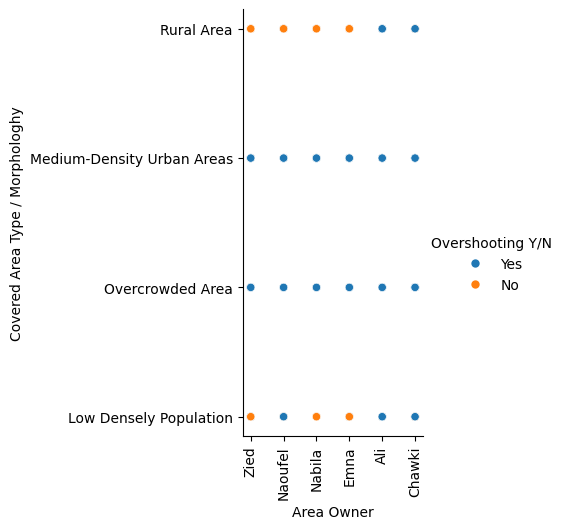

In [40]:
plot = sns.relplot(x='Area Owner', y='Covered Area Type / Morphologhy', hue='Overshooting Y/N', data=df_clean)
plot.set_xticklabels(rotation=90)
plt.show()

The average tilt value of the radio is lower when overshooting is True (mean = 10.40) than when it is False (mean = 13.33)

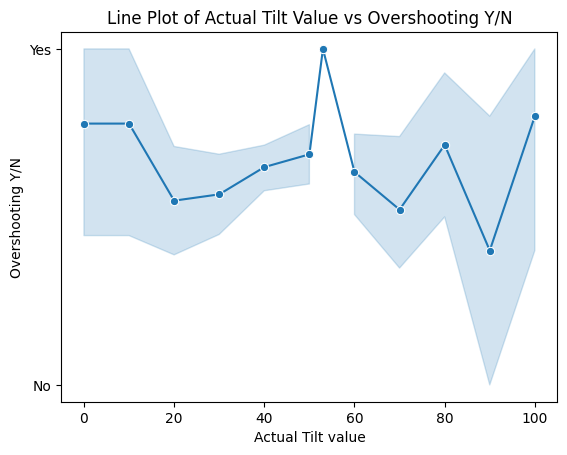

In [41]:
sns.lineplot(x='Actual Tilt value', y='Overshooting Y/N',  data=df_clean, marker='o')
plt.title('Line Plot of Actual Tilt Value vs Overshooting Y/N')
plt.show()

More than 15% percentage of overshooting may cause a positive overshooting

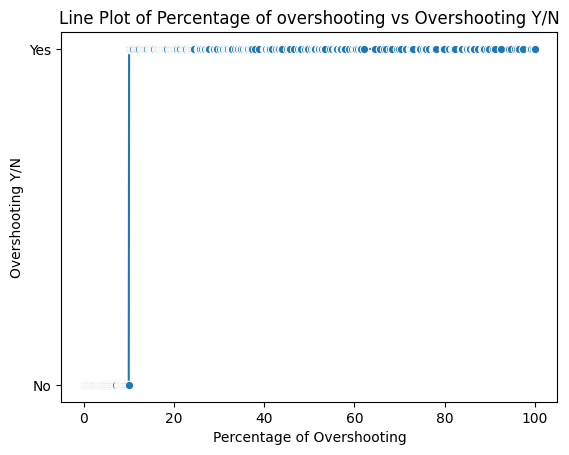

In [42]:
sns.lineplot(x='Percentage of Overshooting', y='Overshooting Y/N',  data=df_clean, marker='o')
plt.title('Line Plot of Percentage of overshooting vs Overshooting Y/N')
plt.show()

### Label Encoding of Overshooting
encoding is applied in the provided code to convert categorical labels into numerical format. In machine learning models, many algorithms require numerical input.

In [7]:
df_clean['Overshooting Y/N']= label_encoder.fit_transform(df_clean['Overshooting Y/N'])
df_clean['Overshooting Y/N'].unique()

array([1, 0])

### OneHot Encoding of both the columns 'Area Owner', 'Covered Area Type / Morphologhy'

In [8]:
df_prep = pd.get_dummies(df_clean, columns = ['Area Owner', 'Covered Area Type / Morphologhy'])

### Dropping the unassecary columns like Sector Name, Nearest Sector and Cell Name

In [9]:
df_prep.drop(['Sector Name', 'Nearest Sector','Cell Name'], axis = 1, inplace = True)

### Analysing Column Correlations

In this plot, it's evident that among the given distances, the correlation between overshooting and the range from 16.5km to 17.6km is the most pronounced. Additionally, when considering different areas, overcrowded locations exhibit the highest correlation with overshooting.

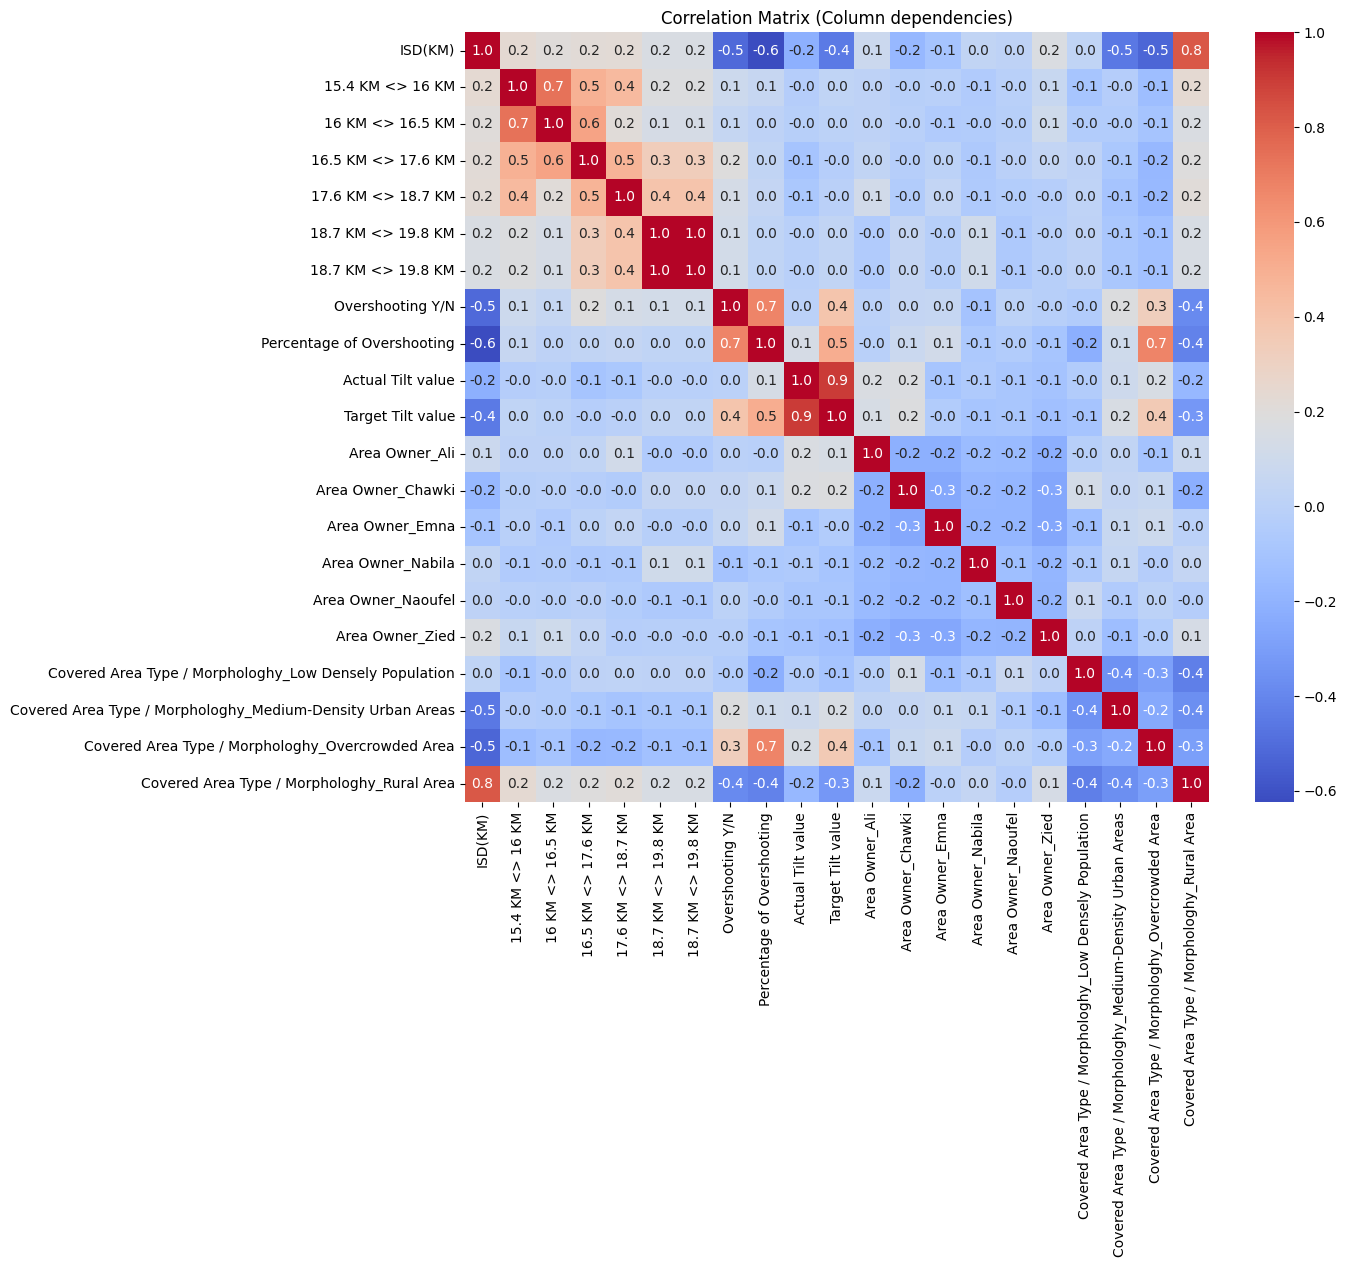

In [46]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_prep.corr(), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlation Matrix (Column dependencies)')
plt.show()

### Analysing 16.5 KM <> 17.6 KM kilometer range 

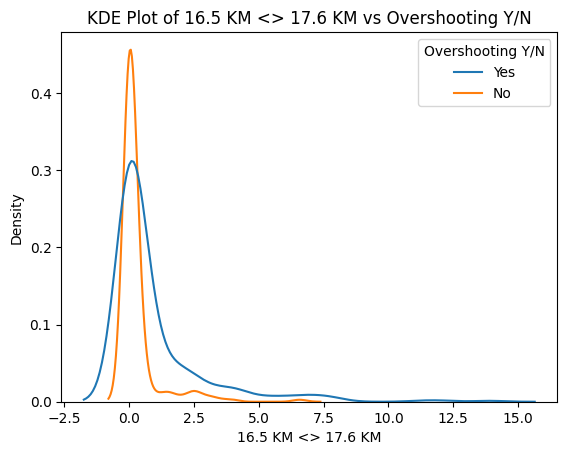

In [47]:
sns.kdeplot(x='16.5 KM <> 17.6 KM', hue='Overshooting Y/N', data=df)
plt.title('KDE Plot of 16.5 KM <> 17.6 KM vs Overshooting Y/N')
plt.show()

### Analysing all the other kilometers

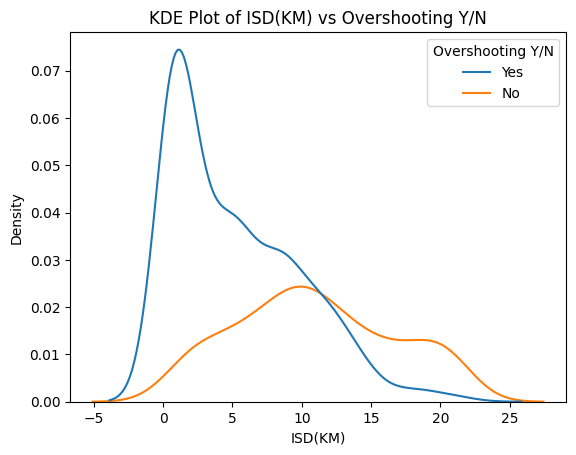

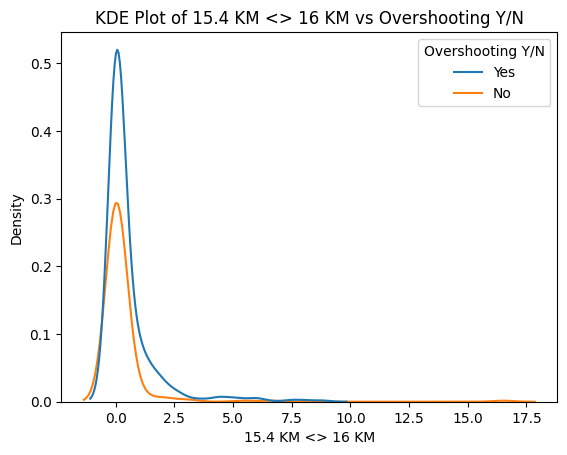

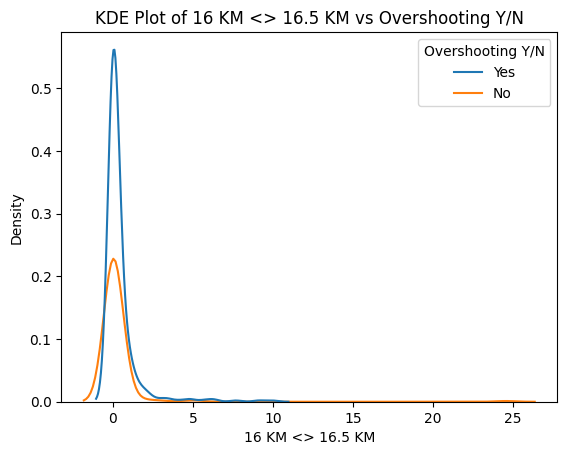

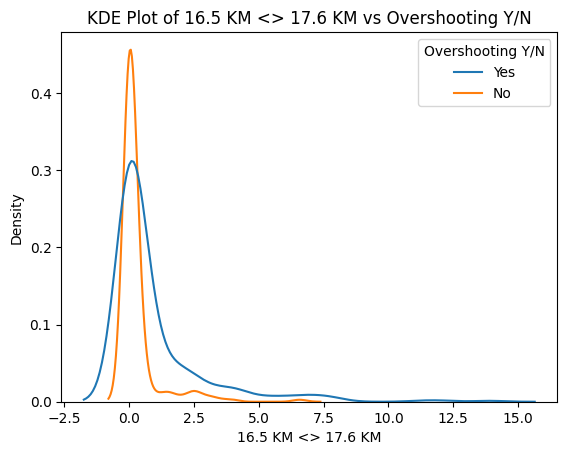

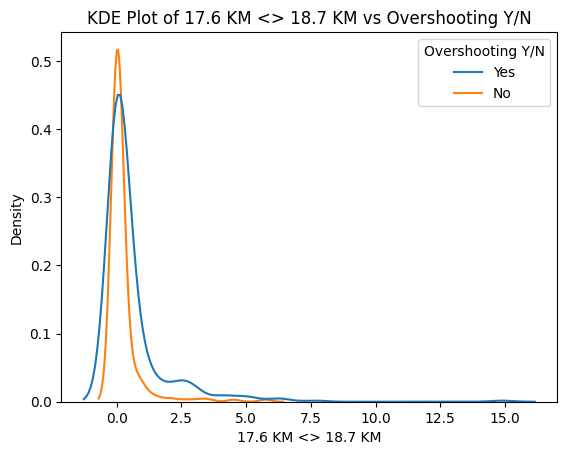

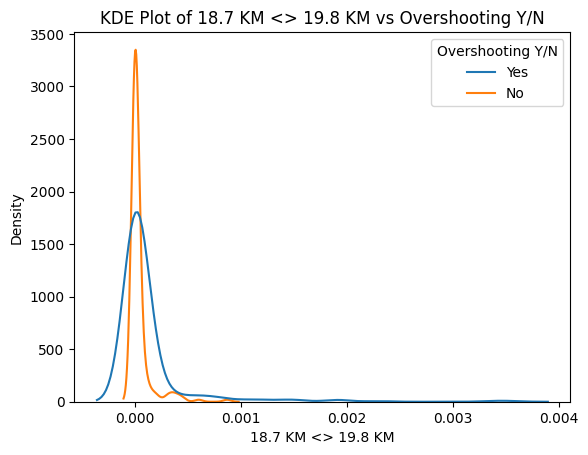

In [48]:
l = ['ISD(KM)', '15.4 KM <> 16 KM', '16 KM <> 16.5 KM', '16.5 KM <> 17.6 KM', '17.6 KM <> 18.7 KM', '18.7 KM <> 19.8 KM']
for i in l:
    sns.kdeplot(x=i, hue='Overshooting Y/N', data=df)
    plt.title(f'KDE Plot of {i} vs Overshooting Y/N')
    plt.show()

### Cheking for imbalanced data

<Axes: xlabel='Overshooting Y/N', ylabel='count'>

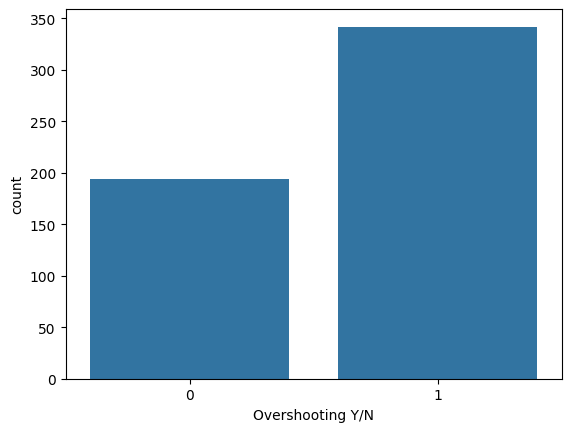

In [49]:
sns.countplot(x='Overshooting Y/N', data=df_prep)

Getting the exact numbers

In [50]:
df_prep['Overshooting Y/N'].value_counts()

Overshooting Y/N
1    342
0    194
Name: count, dtype: int64

In [10]:
df_prep.drop('18.7 KM <> 19.8 KM', axis = 1, inplace = True)

### Oversampling

To make the target balanced

In [13]:
X = df_prep.drop('Overshooting Y/N', axis=1)
y = df_prep['Overshooting Y/N']
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [14]:
y_resampled.value_counts()

Overshooting Y/N
1    342
0    342
Name: count, dtype: int64

## Modeling

### Splitting Data for training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25,random_state=42)

### Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple decision trees and merges their predictions. This ensemble approach often enhances model robustness, reducing the risk of overfitting, and can lead to better generalization performance, which is crucial when working with a limited dataset like ours (536 rows).

In [16]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 100.00%
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Confusion Matrix:
[[83  0]
 [ 0 88]]


### Random Forest Confusion Matrix

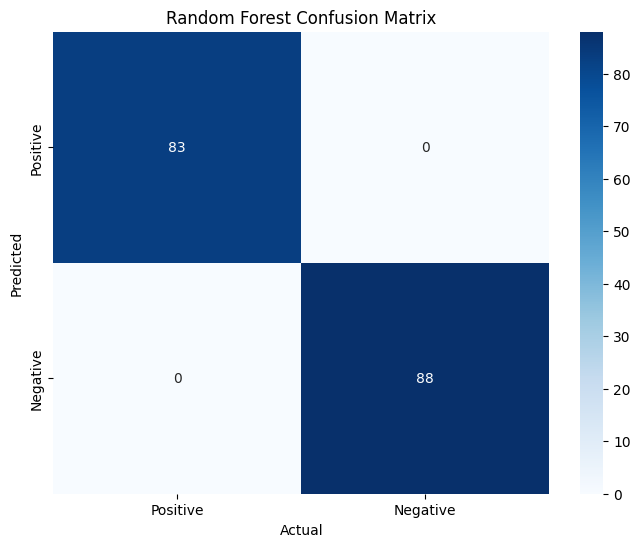

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Analysing Overfitting

In [18]:
train_accuracy = accuracy_score(y_train, rf_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test))

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Training Accuracy: 100.00%
Test Accuracy: 100.00%


Random Forest is widely recognized for its ability to assess feature importance. It calculates the importance of each feature by measuring the decrease in impurity (such as Gini impurity) caused by the feature when making predictions across all decision trees in the ensemble.

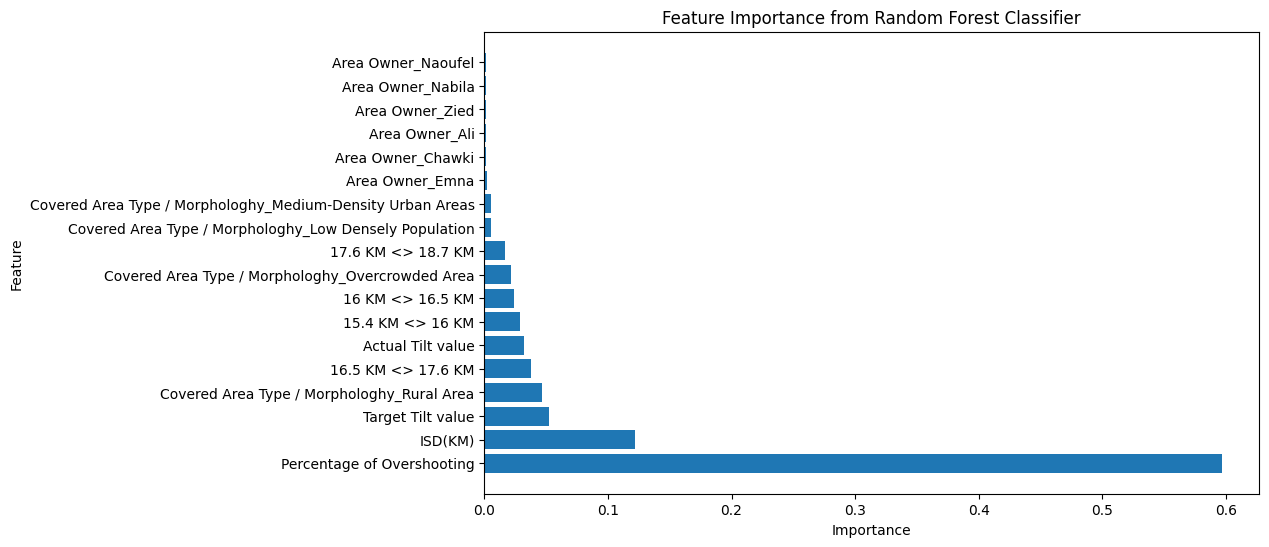

In [19]:
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()


### Testing Random Forest Classifier Model

In [20]:
test_case_data = {
    'ISD(KM)':[12.20], 
    '15.4 KM <> 16 KM':[0.50], 
    '16 KM <> 16.5 KM':[0.266], 
    '16.5 KM <> 17.6 KM':[0.46], 
    '17.6 KM <> 18.7 KM':[0.39], 
    # '18.7 KM <> 19.8 KM':[0.50], 
    'Percentage of Overshooting':[10], 
    'Actual Tilt value':[50], 
    'Target Tilt value':[60], 
    'Area Owner_Ali':[0],
    'Area Owner_Chawki':[0], 
    'Area Owner_Emna':[1], 
    'Area Owner_Nabila':[0], 
    'Area Owner_Naoufel':[0], 
    'Area Owner_Zied':[0], 
    'Covered Area Type / Morphologhy_Low Densely Population':[0], 
    'Covered Area Type / Morphologhy_Medium-Density Urban Areas':[0], 
    'Covered Area Type / Morphologhy_Overcrowded Area':[0], 
    'Covered Area Type / Morphologhy_Rural Area':[1]
}
df_test_case = pd.DataFrame(test_case_data, columns=X.columns)
prediction = rf_classifier.predict(df_test_case)
if prediction[0] == 1:
    print(f'Overshooting Detected ! ')
else:
    print('Not Overshooting')

Overshooting Detected ! 


Saving the Random forest Model

In [21]:
joblib.dump(rf_classifier, "Overshooting_Predictor.joblib")

['Overshooting_Predictor.joblib']

In [22]:
## To load Model 
loaded_rf = joblib.load("Overshooting_Predictor.joblib")
loaded_rf.predict(df_test_case)

array([1])